In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def quantizeWeight(W,BW):
    Wq = np.minimum(np.round(W*np.power(2.0,BW-1.0))*np.power(2.0,1.0-BW),1.0-np.power(2.0,1.0-BW))
    return Wq

def quantizeInput(X,BX):
    return np.minimum(np.round(X*np.power(2.0,BX))*np.power(2.0,-BX) ,1.0-np.power(2.0,-BX))



In [3]:
#print(quantizeWeight(-0.4344,3))
print(quantizeInput(0.22222,10))

0.22265625


In [4]:
def generate_random_data(Nsample,NDP=128):
    X = np.random.uniform(0,1,(NDP,Nsample))
    W = np.random.uniform(-1,1,(NDP,Nsample))
    muX = np.mean(X)
    varX = np.var(X)
    muW = np.mean(W)
    varW = np.var(W)
    return X,W,muX,muW,varX,varW

def estimate_sqnr(NDP, BX, BW, muX, muW, varX, varW):
    x_rms2 = muX**2 + varX
    deltaW = np.power(2.0,1-BW)
    deltaX = np.power(2.0,-BX)
    
    sig2_y = NDP*x_rms2*varW
    sig2_qx2y = NDP*varW*np.square(deltaX)/12.0
    sig2_qw2y = NDP*x_rms2*np.square(deltaW)/12.0
    
    SNR = 10*np.log10(sig2_y/(sig2_qx2y+sig2_qw2y))
    return SNR

def evaluate_sqnr(X,W,BX,BW):
    Yt = np.sum(X*W,axis=0)
    Yq = np.sum(quantizeInput(X,BX)*quantizeWeight(W,BW),axis=0)
    SNR = 10*np.log10(np.true_divide(np.sum(np.var(Yt)),np.sum(np.var(Yt-Yq))))
    return SNR

In [5]:
Nsample = 10000
NDP = 128
BX = 6
BW = 5
X,W,muX,muW,varX,varW = generate_random_data(Nsample,NDP)
print('Predicted SQNR = %f' %estimate_sqnr(NDP,BX,BW,muX,muW,varX,varW))
print('Simulated SQNR = %f' %evaluate_sqnr(X,W,BX,BW))

Predicted SQNR = 29.845892
Simulated SQNR = 29.522562


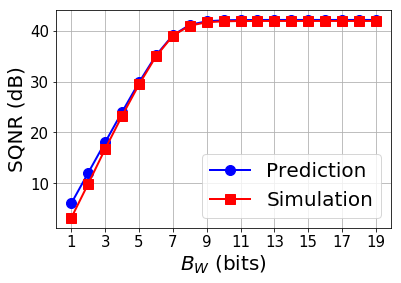

In [6]:
BWs = []
SQNR_predict = []
SQNR_eval = []
X,W,muX,muW,varX,varW = generate_random_data(Nsample,NDP)
for BW in range(1,20):
    BWs.append(BW)
    SQNR_predict.append(estimate_sqnr(NDP,BX,BW,muX,muW,varX,varW))
    SQNR_eval.append(evaluate_sqnr(X,W,BX,BW))
fig,ax=plt.subplots()
line1, = ax.plot(BWs,SQNR_predict,label='Prediction',linewidth=2,color='b',marker='o',markersize=10)
line2, = ax.plot(BWs,SQNR_eval,label='Simulation',linewidth=2,color='r',marker='s',markersize=10)
plt.legend(handles=[line1,line2],loc=0,fontsize=20)
ax.grid()
ax.set_xlabel(r'$B_W$ (bits)',fontsize=20)
ax.set_ylabel('SQNR (dB)',fontsize=20)
ax.tick_params(axis='both',labelsize=15)
ax.set_xticks(np.arange(1,20,2))
plt.show()

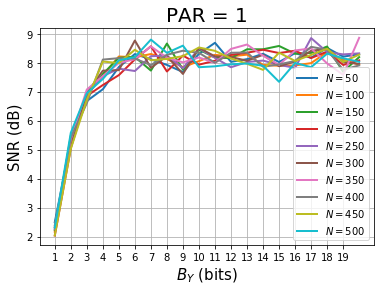

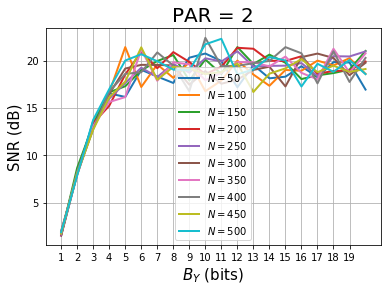

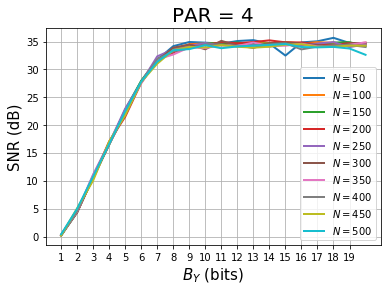

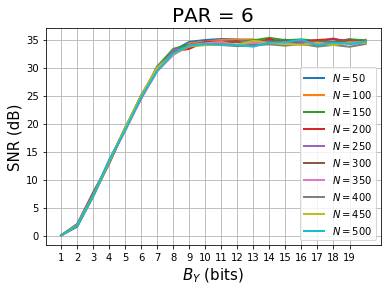

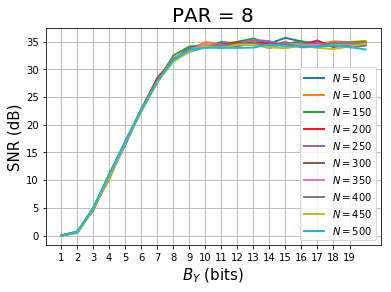

In [19]:
def quantize_result(Y,BY,PAR,varY):
    DR = PAR*np.sqrt(varY)
    Yclipped = np.clip(Y,-DR,DR)
    return DR*np.minimum(1.0-np.power(2.0,1.0-BY),np.round((Yclipped/DR)*np.power(2.0,BY-1.0))*np.power(2.0,1.0-BY))

def evaluate_snr_post_quantization(BW,BX,BY,Nsample,NDP,PAR):
    X,W,muX,muW,varX,varW = generate_random_data(Nsample, NDP)
    varY = NDP*varW*(varX+muX**2)
    Yt = np.sum(X*W,axis=0)
    Yq = np.sum(quantizeInput(X,BX)*quantizeWeight(W,BW),axis=0)
    Yq = quantize_result(Yq,BY,PAR,varY)
    return 10.0*np.log10(np.true_divide(np.sum(np.square(Yt)),np.sum(np.square(Yt-Yq))))

BX=6
BW=6
NDPs = [50,100,150,200,250,300,350,400,450,500]
BYs = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
PARs=[1,2,4,6,8]
for PAR in PARs:
    fig,ax=plt.subplots()
    lines=[]
    for NDP in NDPs:
        SQNR_sim=[]
        for BY in BYs:
            SQNR_sim.append(evaluate_snr_post_quantization(BW,BX,BY,1000,NDP,PAR))
        line, = ax.plot(BYs,SQNR_sim,label = r'$N = $'+str(NDP),linewidth=2)#,marker='o',markersize=10)
        lines.append(line)
    plt.legend(handles=lines,loc=0,fontsize=10)
    ax.grid()
    ax.set_xlabel(r'$B_Y$ (bits)',fontsize=15)
    ax.set_ylabel('SNR (dB)',fontsize=15)
    ax.set_xticks(np.arange(1,20))
    ax.set_title('PAR = '+str(PAR),fontsize=20)
plt.show()

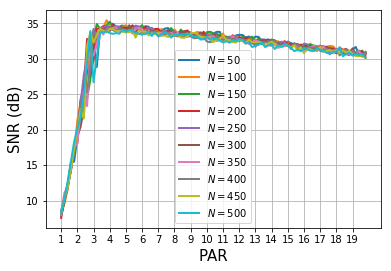

In [21]:
fig,ax=plt.subplots()
BY=9
lines=[]
for NDP in NDPs:
    SQNR_sim=[]
    for PAR in np.arange(1,20,0.2).tolist():
        SQNR_sim.append(evaluate_snr_post_quantization(BW,BX,BY,1000,NDP,PAR))
    line, = ax.plot(np.arange(1,20,0.2),SQNR_sim,label = r'$N = $'+str(NDP),linewidth=2)#,marker='o',markersize=10)
    lines.append(line)
plt.legend(handles=lines,loc=0,fontsize=10)
ax.grid()
ax.set_xlabel('PAR',fontsize=20)
ax.set_ylabel('SNR (dB)',fontsize=20)
ax.yaxis.label.set_fontsize(15)
ax.xaxis.label.set_fontsize(15)
ax.set_xticks(np.arange(1,20))
plt.show()